In [1]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import no_op, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images
from menpo.image import Image

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Define LSVM patch expert

Start by defining `centralize` and `normalize_norm` feature functions:

In [2]:
from menpo.feature import ndfeature

@ndfeature
def centralize(x, channels=True):
    if channels:
        m = np.mean(x, axis=(-2, -1))[..., None, None]
    else:
        m = np.mean(x)
    
    x = x - m
    
    return x


@ndfeature
def normalize_norm(x, channels=True):
    x = centralize(x, channels=channels)
    
    if channels:
        norm = np.asarray(np.linalg.norm(x, axis=(-2, -1))[..., None, None])
    else:
        norm = np.asarray(np.linalg.norm(x))
        
    if np.any(norm == 0):
        raise ValueError("Image has 0 variance - can't be normalized")
    else:
        x = x / norm
    
    return x

Linear Support Vector Machine (LSVM) patch expert:

In [3]:
from sklearn.ensemble import RandomForestRegressor
from menpofit.math.fft_utils import fft_convolve2d_bias_sum

class RFPatchExpert(object):
    r"""
    Random Forest patch expert
    """
    def __init__(self, normalize_callable=normalize_norm, **kwarg):
        self.normalize_callable = normalize_callable
        self.rf = RandomForestRegressor(**kwarg)

    def train(self, X, t):
        # number of samples, number of channels, height and width
        n, k, h, w = X.shape

        # for each sample
        keep = []
        count = 0
        for j, x in enumerate(X):
            try:
                # normalize it if required
                x = self.normalize_callable(x)
                X[count] = x
                keep.append(j)
                count += 1
            except:
                pass
        
        X = X[:count]
        t = t[keep]

        X = X.reshape(n, -1)
        
        self.rf.fit(X, t)
        
        return self
    
    def predict(self, x):
        # normalize if required
        x = self.normalize_callable(x)
        # compute svm response
        return self.rf.predict(x.as_vector())

## Load images

In [4]:
images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=10):
    if i.n_channels == 3:
        i = i.crop_to_landmarks_proportion(0.8)
        i = i.rescale_landmarks_to_diagonal_range(200)
        labeller(i, 'PTS', ibug_face_66)
        images.append(i)

Importing assets: [==========] 100% (10/10) - done.                             


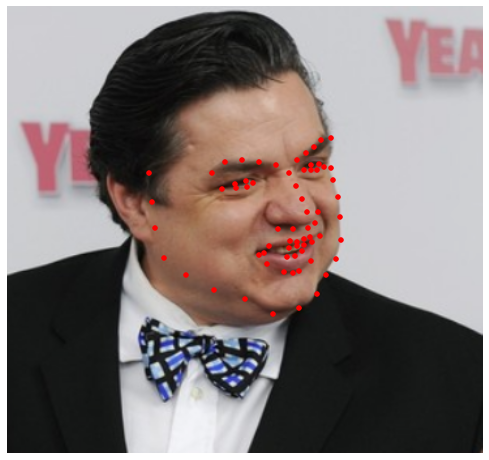

In [5]:
visualize_images(images)

In [6]:
shapes = [i.landmarks['ibug_face_66'].lms for i in images]

## Train a LSVM patch expert

In [7]:
def build_context_grid_mask(grid, positive_neighbourhood):
    positive_mask = np.zeros(grid.shape[:2], dtype=np.bool)
    centre = np.floor(np.asarray(positive_mask.shape) / 2)
    centre = np.require(centre, dtype=int)
    positive_neighbourhood = np.asarray(positive_neighbourhood) - 1
    start = centre - positive_neighbourhood
    end = centre + positive_neighbourhood
    positive_mask[start[0]:end[0]:1, start[1]:end[1]:1] = True
    return positive_mask

In [74]:
from scipy.stats import multivariate_normal
from menpo.shape import PointCloud
from menpofit.base import build_grid
from menpofit.clm.patch_experts import check_context_size

patch_size = (32, 32) 
context_size= 1
covariance = 3
landmark = 42

# check parameters
context_size = check_context_size(context_size, patch_size)

# generate sample offsets
context_grid = build_grid(context_size)
sample_offsets = PointCloud(context_grid.reshape((-1, 2)))

# generate responses
rs = []
for o in sample_offsets.points:
    # build desired response
    grid = build_grid(patch_size)
    r = multivariate_normal(mean=np.zeros(2), 
                            cov=covariance).pdf(grid + o)
    rs.append(r)

# turn list into ndarray
rs = np.asarray(rs).reshape((sample_offsets.n_points, -1))

samples = []
responses = []
for (i, s) in zip(images, shapes):
    # choose appropriate landmark
    centre = PointCloud([s.points[landmark]])
    # extract positive sample
    p = i.extract_patches(centre, patch_size=patch_size,
                          sample_offsets=sample_offsets,
                          as_single_array=True)[..., ::4, ::4]

    # append both patches and labels to their list
    samples.append(p[0])
    responses.append(rs)

samples = np.asarray(samples).reshape((-1,) + p.shape[2:])
responses = np.asarray(responses).reshape((samples.shape[0], -1))

# train patch experts
patch_expert = RFPatchExpert(max_depth=10,
                             max_features=0.1).train(samples[::2], responses[::2])

Visualize ideal response:

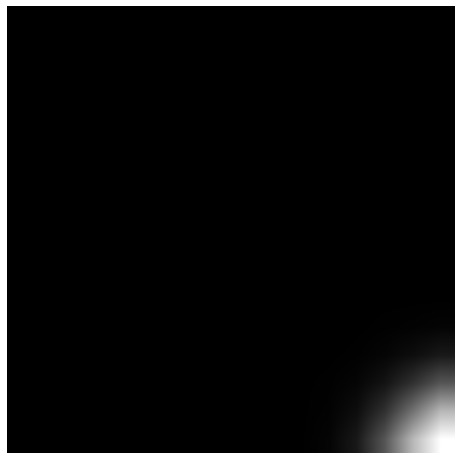

In [43]:
visualize_images([Image(r.reshape(patch_size)) for r in rs])

Visualize samples:

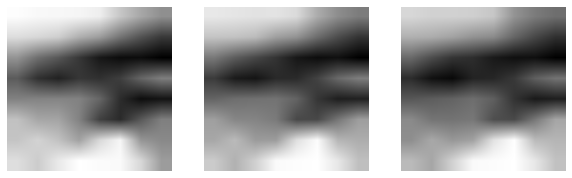

In [44]:
samples_images = [Image(s) for s in samples]

visualize_images(samples_images)

Visualize response on training patches:

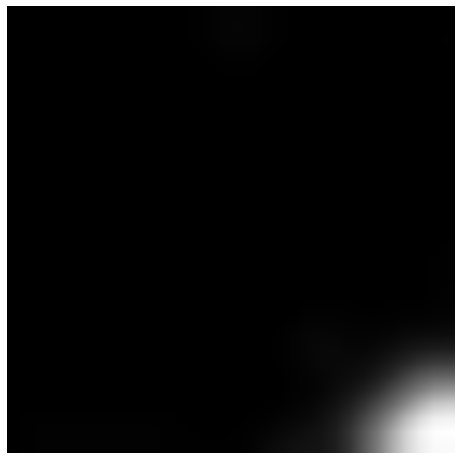

In [75]:
response_maps = [patch_expert.predict(Image(s)) for s in samples]

visualize_images([Image(r.reshape(patch_size)) for r in response_maps])

In [76]:
%%timeit 

for _ in range(68):
    patch_expert.predict(Image(s))

10 loops, best of 3: 22.4 ms per loop


In [77]:
patch_expert.rf.score(samples[1::2].reshape((responses[1::2].shape[0], -1)), responses[1::2])

-0.12152117582794686